In [1]:
%matplotlib inline
import emcee
import corner
import time
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator
import scipy.integrate as integrate
import scipy.linalg as linalg
from multiprocessing.pool import ThreadPool
import os
from getdist import plots, MCSamples
import getdist, IPython

global argsortz

os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
snnamei,zsni,mBi,smBi = np.genfromtxt("data/pantheon_full.txt", unpack=True)
snnamei,zsni,mui,smui = np.genfromtxt("data/pantheon_fullSorted.txt", unpack=True)
covsysraw = np.genfromtxt("data/pantheon_sys_full.txt", unpack=True)

nsn = len(snnamei)
argsortz = np.argsort(zsni)

In [3]:
c = 299792.458#km/s
wr = 9.2364e-5
wb = .0493
pl.rcParams['text.usetex']=False

In [4]:
covsyspanth = np.zeros((nsn,nsn))
k = 0
for i in range(nsn):
    for j in range(nsn):
        covsyspanth[i,j] = covsysraw[k]
        k=k+1

covstatpanth = np.diag(smBi**2)
covpanth = covstatpanth + covsyspanth

covpanthsort = np.zeros((nsn,nsn))
for i in range(nsn):
    for j in range(nsn):
        covpanthsort[i,j]=covpanth[argsortz[i],argsortz[j]]

invcovsort = linalg.inv(covpanthsort)

In [6]:
#E(z)^2
def Ez2(z,pars):
    if len(pars)==4:
        H0, wm, wl, f = pars
    else:
        H0, wm, wl = pars
    return wm*(1+z)**3+(1-wm-wl)*(1+z)**2+wl

#E(z)^(-1)
def Ez_1(z,pars):
    if len(pars)==4:
        H0, wm, wl, f = pars
    else:
        H0, wm, wl = pars
    return 1./np.sqrt(wm*(1+z)**3+(1-wm-wl)*(1+z)**2+wl)

def odesys(y, z, pars):
    dydz = Ez_1(z,pars)
    return dydz

def solsys(y0, z, pars):
    return integrate.odeint(odesys, y0, z, args=(pars,), atol=1e-6)

#Distancia comovel de linha-de-visada adimensional (=dc/dH)
def Dcmodel(z,pars):
    y0 = 0.
    z = np.append([0.],z)
    sol = solsys(y0, z, pars)[:,0]
    sol = np.delete(sol,0)
    return sol

#Distancia comovel transversal adimensional (=dm/dH)
def Dmmodel(z,pars):
    if len(pars)==4:
        H0, wm, wl, f = pars
    else:
        H0, wm, wl = pars
    wk = 1. - wm - wl
    Dcm = Dcmodel(z,pars)
    if wk < 0:
        return np.sin(np.sqrt(-wk)*Dcm)/np.sqrt(-wk)
    elif wk > 0:
        return np.sinh(np.sqrt(wk)*Dcm)/np.sqrt(wk)
    return Dcm

def Dlmodel(z,pars):
    return (1+z)*Dmmodel(z,pars)

#Distancia comovel transversal in Mpc
def dmmodel(z,pars):
    if len(pars)==4:
        H0, wm, wl, f = pars
    else:
        H0, wm, wl = pars
    dH = c/H0
    wk = 1. - wm - wl
    Dcm = Dcmodel(z,pars)
    if wk < 0:
        return dH*np.sin(np.sqrt(-wk)*Dcm)/np.sqrt(-wk)
    elif wk > 0:
        return dH*np.sinh(np.sqrt(wk)*Dcm)/np.sqrt(wk)
    return dH*Dcm

def dlmodel(z,pars):
    return (1+z)*dmmodel(z,pars)

In [7]:
def chi2snproj1(theta):
    Ez2i = Ez2(zsni,theta)
    if np.any(Ez2i<0):
        return np.inf
    Dlmodi = Dlmodel(zsni,theta)
    if np.any(Dlmodi<=0):
        return np.inf
    mBmod = 5.*np.log10(Dlmodi)
    dmu = mBmod-mui#delta r
    SA  = np.sum(invcovsort)
    Sr  = np.sum(np.dot(dmu.T,invcovsort))
    Srr = np.dot(np.dot(dmu.T,invcovsort),dmu)
    return Srr - Sr**2./SA

def chi2snproj(theta):
    H0, wm, wl, f = theta
    Ez2i = Ez2(zsni,theta)
    if np.any(Ez2i<0):
        return np.inf
    Dlmodi = Dlmodel(zsni,theta)
    if np.any(Dlmodi<=0):
        return np.inf
    mBmod = 5.*np.log10(Dlmodi)
    dmu = mBmod-mui#delta r
    invcovcorr = invcovsort/f**2
    SA  = np.sum(invcovcorr)
    Sr  = np.sum(np.dot(dmu.T,invcovcorr))
    Srr = np.dot(np.dot(dmu.T,invcovcorr),dmu)
    return Srr - Sr**2./SA

In [8]:
par0 = [70, .31, .73, 1.1]
print(chi2snproj(par0))

953.2353805378079


In [9]:
def chi2snproj1(theta):
    Ez2i = Ez2(zsni,theta)
    if np.any(Ez2i<0):
        return np.inf
    Dlmodi = Dlmodel(zsni,theta)
    if np.any(Dlmodi<=0):
        return np.inf
    mBmod = 5.*np.log10(Dlmodi)
    dmu = mBmod-mui#delta r
    SA  = np.sum(invcovsort)
    Sr  = np.sum(np.dot(dmu.T,invcovsort))
    Srr = np.dot(np.dot(dmu.T,invcovsort),dmu)
    return Srr - Sr**2./SA

def chi2snproj(theta):
    H0, wm, wl, f = theta
    Ez2i = Ez2(zsni,theta)
    if np.any(Ez2i<0):
        return np.inf
    Dlmodi = Dlmodel(zsni,theta)
    if np.any(Dlmodi<=0):
        return np.inf
    mBmod = 5.*np.log10(Dlmodi)
    dmu = mBmod-mui#delta r
    invcovcorr = invcovsort/f**2
    SA  = np.sum(invcovcorr)
    Sr  = np.sum(np.dot(dmu.T,invcovcorr))
    Srr = np.dot(np.dot(dmu.T,invcovcorr),dmu)
    return Srr - Sr**2./SA
# Define the probability function as likelihood * prior.    
def lnprior1(theta):
    H0, wm, wl = theta
    if 0.0 < wm < 3.0 and 50. < H0 < 100. and -1.0 < wl < 3.0:
        return 0.0    #flat prior
    return -np.inf

def lnlike1(theta):
    chi2 = chi2snproj1(theta)
    return -0.5*chi2
 
def lnprob1(theta):
    lp = lnprior1(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike1(theta)

def lnprior(theta):
    H0, wm, wl, f = theta
    if 0.0 < wm < 3.0 and 50. < H0 < 100. and -1.0 < wl < 3.0 and .1 < f < 5:
        return 0.0    #flat prior
    return -np.inf

ndata = len(invcovsort)

def lnlike(theta):
    H0, wm, wl, f = theta
    return -.5*(chi2snproj(theta))-ndata*np.log(f)
 
def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [10]:
# Find the maximum likelihood value.
def find_bestfit(lnlike,par_ml):#,data):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda *args: -2 * lnlike(*args)
    result = op.minimize(chi2, par_ml)#, args=data)
    if not result['success']:
        result = op.minimize(chi2, par_ml,method='Nelder-Mead',options={'maxiter': 10000})#, args=data
    par_ml = result["x"]
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    #ndof = len(data[0])-ndim
    #print('chi2red =',result['fun']/ndof)
    #print(result)
    t2 = time.time()
    print("tempo total: {0:5.3f} seg".format(t2-t1))
    return result

def run_emcee(par_ml,nwalkers,lnprob,ainput,nstep):
    # Set up the sampler.
    ndim = len(par_ml)
    pos = [par_ml + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    #sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, a=ainput, threads=threadsin)#args=data,
    #sampler.run_mcmc(pos, nstep, progress=True);
    
    with ThreadPool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, a=ainput, pool=pool)
        #start = time.time()
        sampler.run_mcmc(pos, nstep, progress=True)
        #end = time.time()
        #multi_time = end - start
    accept = sampler.acceptance_fraction
    print('Acceptance fraction:',accept)
    print('Minimum acceptance:',np.amin(accept))
    print('Maximum acceptance:',np.amax(accept))
    
    #print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    #print("{0:.1f} times faster than serial".format(serial_time / multi_time))
    return sampler

def plot_chains(sampler,par_ml,parlabtex):
    ndim = len(par_ml)
    pl.clf()
    fig, axes = pl.subplots(ndim, 1, sharex=True, figsize=(8, 9))
    for i in range(ndim):
        axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=0.4)
        axes[i].yaxis.set_major_locator(MaxNLocator(5))
        axes[i].axhline(par_ml[i], color="#888888", lw=2)
        axes[i].set_ylabel(parlabtex[i])
        
    axes[ndim-1].set_xlabel("step number")
    
    fig.tight_layout(h_pad=0.0)
    pl.show()
    #fig.show()
#fig.savefig(prefix+"-time.png")

def tira_burnin(sampler,burnin,ndim):
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    return samples

def burninthin(sampler,tau):
    taumax = np.amax(tau)
    taumin = np.amin(tau)
    samples = sampler.get_chain(discard=int(2*taumax), thin=int(taumin/2), flat=True)
    print(samples.shape)
    return samples

# Make the triangle plot.
#def plot_cornertriangle(samples,nstep,burnin,parlabtex,par_ml):
#    fig = corner.corner(samples,bins=np.sqrt(nstep-burnin),labels=parlabtex,truths=par_ml)
def plot_cornertriangle(samples,parlabtex,par_ml):
    #fig = corner.corner(samples,bins=np.sqrt(len(samples)),labels=parlabtex,truths=par_ml)
    fig = corner.corner(samples,bins=50,labels=parlabtex,truths=par_ml)
    pl.show()
#fig.savefig(prefix+"Corner.png")

def MC_result(samples, par_ml, parnames):
    ndim = len(par_ml)
    par_mean = np.mean(samples,axis=0)
    par_median = np.percentile(samples, [50], axis=0)[0]
    par_valm = np.percentile(samples, [15.865], axis=0)[0]
    par_valp = np.percentile(samples, [84.135], axis=0)[0]
    par_valm2 = np.percentile(samples, [2.275013194800002], axis=0)[0]
    par_valp2 = np.percentile(samples, [97.7249868052], axis=0)[0]
    par_sigm = par_mean - par_valm
    par_sigp = par_valp - par_mean
    par_sigm2 = par_mean - par_valm2
    par_sigp2 = par_valp2 - par_mean
    print('MCMC result:')
    for i in range(ndim):
        print("""{0} = {1:5.5f} +{2:5.5f} +{3:5.5f} -{4:5.5f} -{5:5.5f} (median: {6:5.5f}, ml: {7:5.5f})"""\
              .format(parnames[i],par_mean[i],par_sigp[i],par_sigp2[i],par_sigm[i],par_sigm2[i],par_median[i],par_ml[i]))

In [11]:
par0 = [70, .31, .73, 1.1]
print(Dcmodel(4.3,par0))
#print(dlmodel(4.3,par0))
print(Dcmodel([2.,4.3],par0))
#print(dlmodel(np.array([2.,4.3]),par0))
#print(dlmodel([2.,4.3],par0)) #Nao funciona sem np.array

[1.72792619]
[1.21689665 1.72792629]


In [12]:
print(Dmmodel([1.1,2],par0))
#print(chi2snmarg(par0, zsni,mui,smui))

[0.82796383 1.20491869]


In [13]:
print(-2*lnprob(par0))#=chi2

1153.005517407673


In [14]:
par_ml  = [69.1929957609451,0.2480895086492853, 0.6862431649000225, 1.1]
par_ml1 = [69.1929957609451,0.2480895086492853, 0.6862431649000225]
ndim = len(par_ml)
prefix = 'LcdmPanthCovCorr'
nstep = 3500
nstep1 = 3500
parlabels = ["H_0",r"\Omega_m", r"\Omega_\Lambda", 'f']#Latex sem $$
parlabtex = ["$H_0$",r"$\Omega_m$", r"$\Omega_\Lambda$", '$f$']#Latex com $$
parnames = ['H0','wm','wl','f']
parlabels1 = ["H_0",r"\Omega_m", r"\Omega_\Lambda"]#Latex sem $$
parlabtex1 = ["$H_0$",r"$\Omega_m$", r"$\Omega_\Lambda$"]#Latex com $$
parnames1 = ['H0','wm','wl']

In [15]:
result1 = find_bestfit(lnprob1,par_ml1)
print(result1,'\n')
par_ml1 = result1["x"]
result = find_bestfit(lnprob,par_ml)
print(result,'\n')
par_ml = result["x"]

Maximum likelihood result:
H0  =  50.53082524617082
wm  =  0.34589169516973317
wl  =  0.8224716532279015
chi2min = 1151.9252074025571
tempo total: 0.716 seg
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1151.9252074025571
             x: [ 5.053e+01  3.459e-01  8.225e-01]
           nit: 88
          nfev: 169
 final_simplex: (array([[ 5.053e+01,  3.459e-01,  8.225e-01],
                       [ 5.053e+01,  3.459e-01,  8.225e-01],
                       [ 5.053e+01,  3.459e-01,  8.225e-01],
                       [ 5.053e+01,  3.459e-01,  8.225e-01]]), array([ 1.152e+03,  1.152e+03,  1.152e+03,  1.152e+03])) 

Maximum likelihood result:
H0  =  93.09504793137371
wm  =  0.3458929168862923
wl  =  0.8224759225263341
f  =  1.0484116796007303
chi2min = 1147.0895005151094
tempo total: 4.208 seg
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1147.0895005151094
          

In [16]:
print(par_ml1)
print(par_ml)

[50.53082525  0.3458917   0.82247165]
[93.09504793  0.34589292  0.82247592  1.04841168]


In [17]:
#samplersn = run_emcee(par_mlSN,100,lnprobsn,2.0,(zsni,mui,invcovsort),16,nstep)
sampler1 = run_emcee(par_ml1,100,lnprob1,2.0,nstep1)

100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [06:05<00:00,  9.58it/s]

Acceptance fraction: [0.59457143 0.60171429 0.60714286 0.58514286 0.60085714 0.58857143
 0.59685714 0.60885714 0.61571429 0.59171429 0.61057143 0.61114286
 0.59       0.59485714 0.58457143 0.60114286 0.60314286 0.60514286
 0.62142857 0.59485714 0.60771429 0.592      0.59285714 0.59542857
 0.60171429 0.602      0.59914286 0.594      0.61828571 0.62028571
 0.60142857 0.60657143 0.61485714 0.61514286 0.60628571 0.58228571
 0.60742857 0.60714286 0.59771429 0.604      0.58371429 0.60114286
 0.58885714 0.59228571 0.58028571 0.58714286 0.57542857 0.588
 0.58685714 0.59714286 0.62171429 0.60085714 0.60771429 0.59542857
 0.60514286 0.60457143 0.62771429 0.58971429 0.58971429 0.58457143
 0.592      0.60485714 0.60171429 0.58771429 0.59428571 0.59428571
 0.62257143 0.60057143 0.58428571 0.60885714 0.60514286 0.60485714
 0.602      0.61571429 0.60228571 0.59514286 0.60228571 0.60485714
 0.60228571 0.58942857 0.58314286 0.59971429 0.58657143 0.60228571
 0.60114286 0.60542857 0.60085714 0.59514286 0

In [18]:
tau1 = sampler1.get_autocorr_time()
print(tau1)
tau1max = np.amax(tau1)
r = nstep1/tau1max
print(r)
if(r>50):
    print('Convergiu! :)')
else:
    print('Nao convergiu... :(')

[52.18567727 37.40400243 38.12043476]
67.06821072891339
Convergiu! :)


<Figure size 640x480 with 0 Axes>

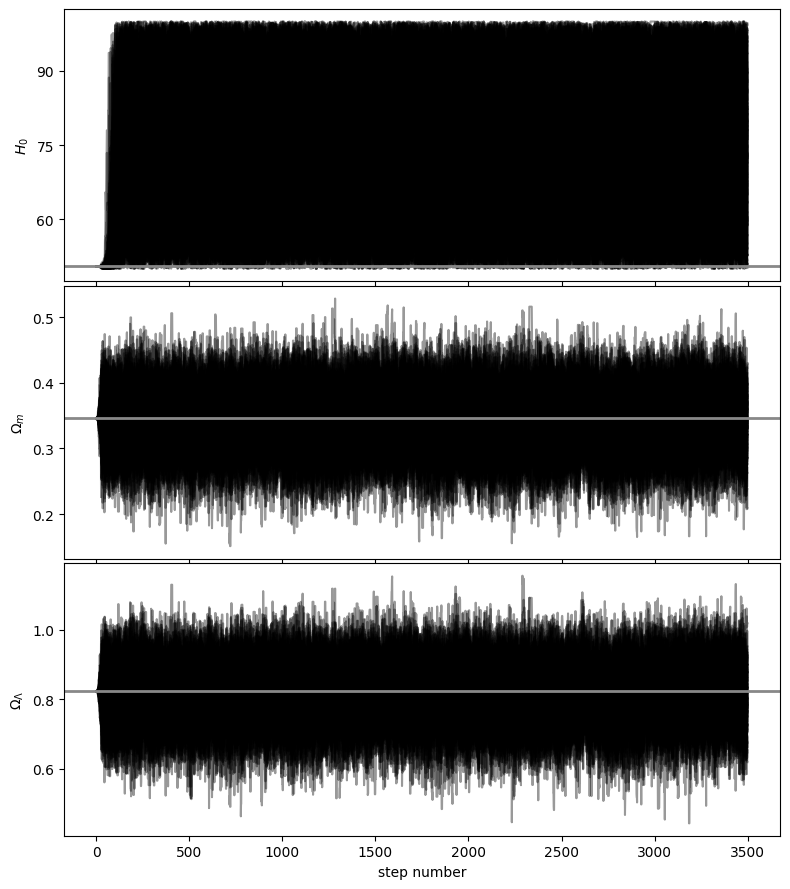

(18800, 3)


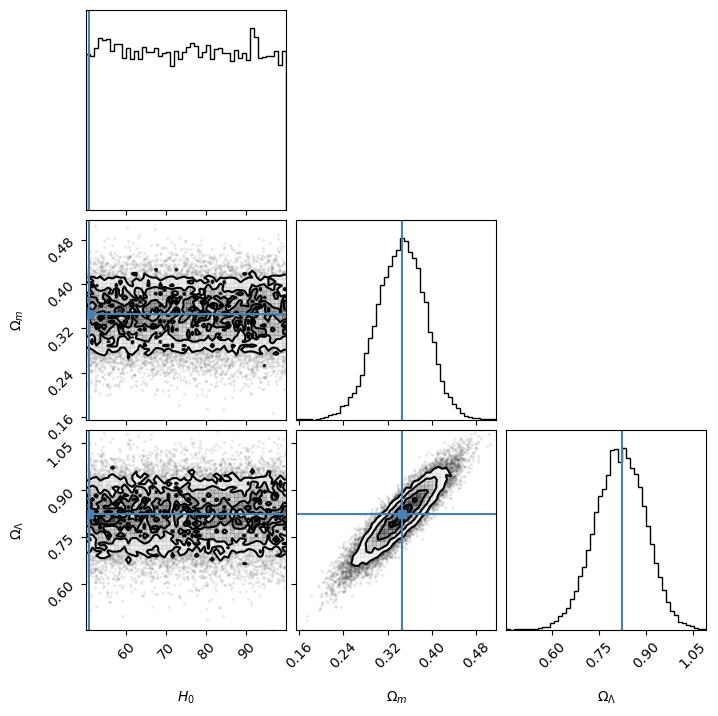

In [20]:
plot_chains(sampler1,par_ml1,parlabtex1)
samples1 = burninthin(sampler1,tau1)
plot_cornertriangle(samples1,parlabtex1,par_ml1)

In [21]:
MC_result(samples1,par_ml1, parnames1)

MCMC result:
H0 = 74.86379 +17.07129 +23.97545 -17.16770 -23.69332 (median: 74.94591, ml: 50.53083)
wm = 0.34431 +0.04396 +0.08647 -0.04382 -0.09147 (median: 0.34539, ml: 0.34589)
wl = 0.81843 +0.08090 +0.15689 -0.08099 -0.16661 (median: 0.81991, ml: 0.82247)


In [5]:
gsamples1 = MCSamples(samples=samples1,names=parnames1,labels=parlabels1)
gsamples1.updateSettings({'contours': [0.682689492137, 0.954499736104, 0.997300203937]})

NameError: name 'samples1' is not defined

In [6]:
g = plots.getSubplotPlotter()#width_inch=10)
g.triangle_plot([gsamples1], ('wm', 'wl'), filled=False,legend_labels=['Uncorrected Pantheon+'])
g.export('fig/g1_NoH0-triangle.pdf')

NameError: name 'gsamples1' is not defined

In [22]:
sampler = run_emcee(par_ml,100,lnprob,2.0,nstep)

100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [17:33<00:00,  3.32it/s]

Acceptance fraction: [0.568      0.52857143 0.54342857 0.544      0.52857143 0.52857143
 0.534      0.54885714 0.57171429 0.54028571 0.56428571 0.55771429
 0.54742857 0.52142857 0.54714286 0.54542857 0.54914286 0.548
 0.56714286 0.53971429 0.53914286 0.52971429 0.54914286 0.52457143
 0.53971429 0.54942857 0.564      0.55457143 0.55371429 0.54914286
 0.55171429 0.55457143 0.55314286 0.55228571 0.56314286 0.53742857
 0.54857143 0.54457143 0.54771429 0.55228571 0.54257143 0.54714286
 0.55057143 0.54285714 0.54057143 0.55314286 0.54657143 0.53285714
 0.53657143 0.53428571 0.53771429 0.552      0.56142857 0.56085714
 0.558      0.54314286 0.57285714 0.53971429 0.542      0.54085714
 0.54942857 0.55085714 0.54771429 0.53971429 0.53771429 0.53542857
 0.55914286 0.54657143 0.54371429 0.56028571 0.53371429 0.55542857
 0.55857143 0.54228571 0.55142857 0.55485714 0.554      0.55514286
 0.56085714 0.55028571 0.55       0.55114286 0.53314286 0.56228571
 0.54428571 0.56285714 0.56       0.54828571 0

In [23]:
tau = sampler.get_autocorr_time(tol=0)
print(tau)
taumax = np.amax(tau)
r = nstep/taumax
print(r)
if(r>50):
    print('Convergiu! :)')
else:
    print('Nao convergiu... :(')

[54.7278962  44.55955873 44.37764509 43.57611658]
63.952759803889215
Convergiu! :)


<Figure size 640x480 with 0 Axes>

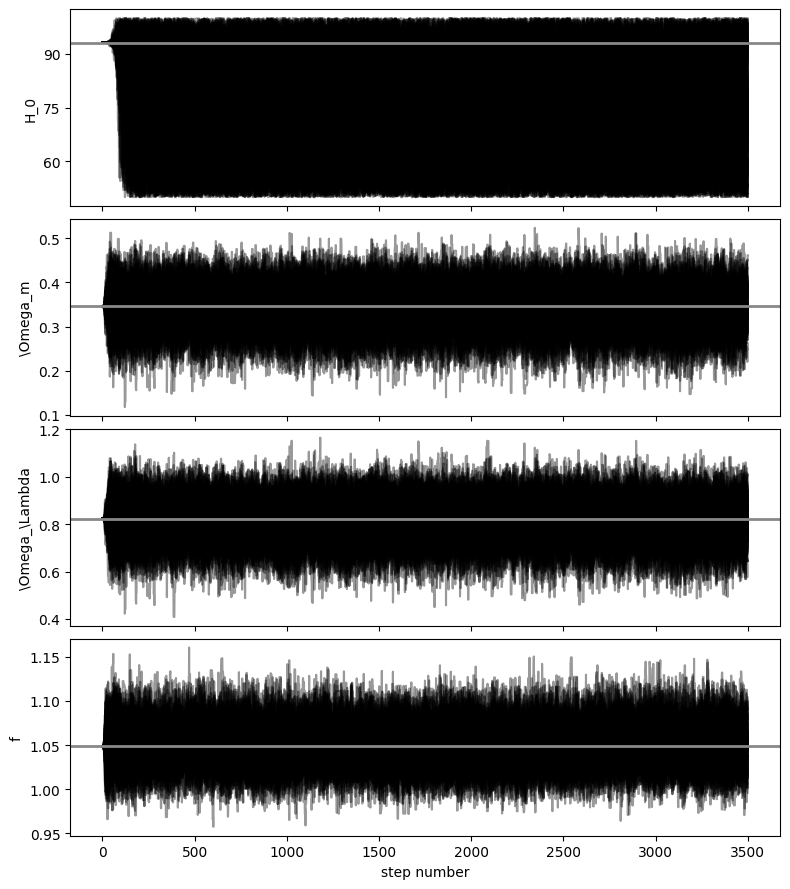

(16100, 4)


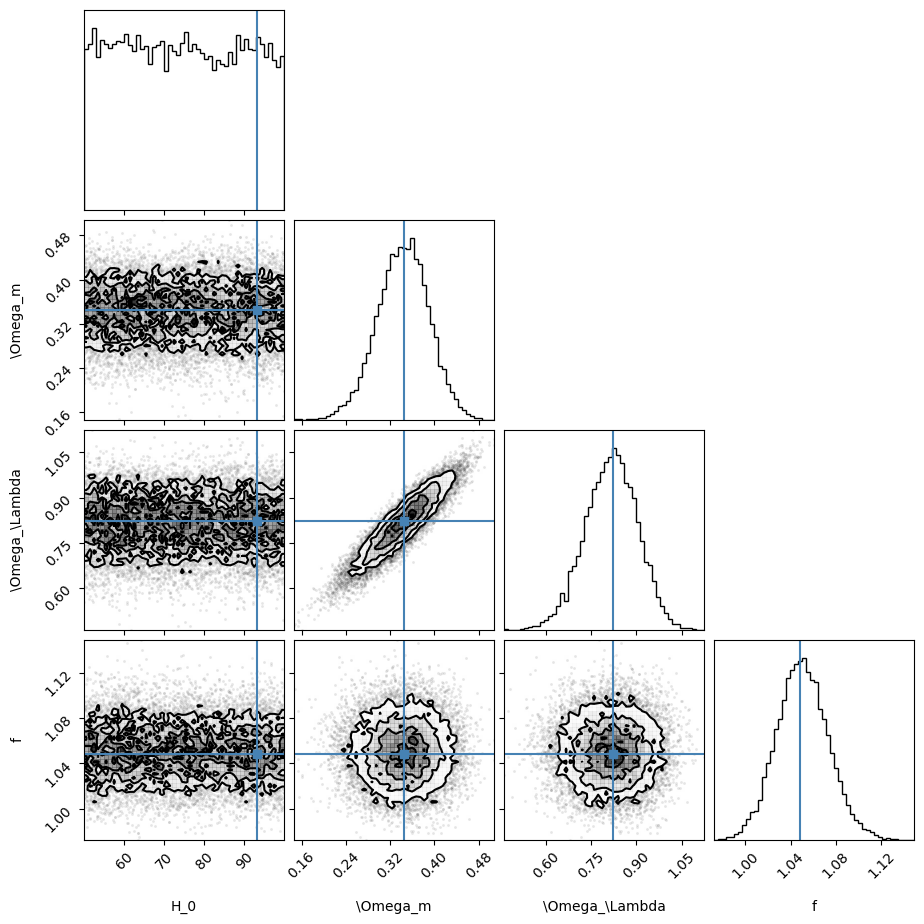

In [24]:
plot_chains(sampler,par_ml,parlabels)
samples = burninthin(sampler,tau)
plot_cornertriangle(samples,parlabels,par_ml)

In [25]:
MC_result(samples, par_ml, parnames)

MCMC result:
H0 = 74.69434 +17.23530 +24.15449 -16.99363 -23.54701 (median: 74.56318, ml: 93.09505)
wm = 0.34265 +0.04610 +0.09104 -0.04645 -0.09861 (median: 0.34391, ml: 0.34589)
wl = 0.81534 +0.08643 +0.16510 -0.08649 -0.18026 (median: 0.81803, ml: 0.82248)
f = 1.05049 +0.02264 +0.04808 -0.02274 -0.04538 (median: 1.05006, ml: 1.04841)


In [26]:
gsamples = MCSamples(samples=samples,names=parnames,labels=parlabels)
gsamples.updateSettings({'contours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


In [27]:
gsamples1 = MCSamples(samples=samples1,names=parnames1,labels=parlabels1)
gsamples1.updateSettings({'contours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


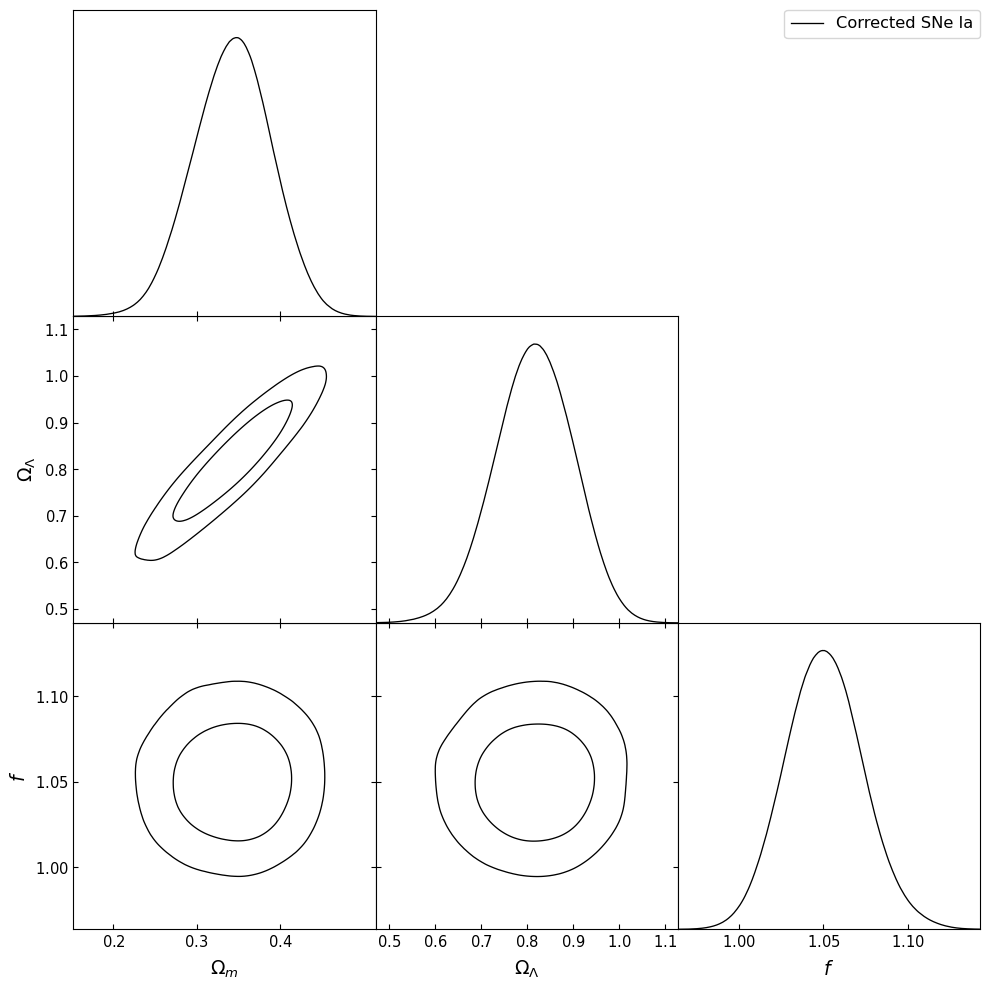

In [27]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamples], ['wm','wl','f'], filled=False, legend_labels=['Corrected SNe Ia'])
g.export('fig/g_NoH0-triangle.pdf')
pl.show()

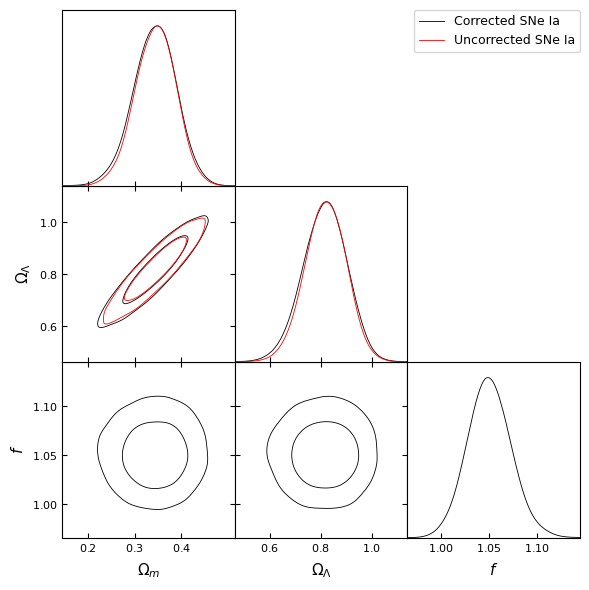

In [33]:
gComp = plots.getSubplotPlotter(subplot_size=2)
gComp.triangle_plot([gsamples, gsamples1], ['wm','wl','f'], filled=False, legend_labels=['Corrected SNe Ia', 'Uncorrected SNe Ia'])
gComp.export('fig/g_Comp_NoH0-triangle175.pdf')
pl.show()

In [29]:
ndim1 = len(parnames1)
for i in range(ndim1):
    for j in range(1,4):
        print(gsamples1.getInlineLatex(parnames1[i],limit=j))
        
print(gsamples1.getTable().tableTex())

H_0 = 75\pm 10
H_0 = 75^{+20}_{-20}
H_0 = 75^{+30}_{-20}
\Omega_m = 0.344\pm 0.044
\Omega_m = 0.344^{+0.086}_{-0.090}
\Omega_m = 0.34^{+0.13}_{-0.14}
\Omega_\Lambda = 0.817\pm 0.081
\Omega_\Lambda = 0.82^{+0.16}_{-0.17}
\Omega_\Lambda = 0.82^{+0.24}_{-0.26}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $75^{+20}_{-20}            $\\

{\boldmath$\Omega_m       $} & $0.344^{+0.086}_{-0.090}   $\\

{\boldmath$\Omega_\Lambda $} & $0.82^{+0.16}_{-0.17}      $\\
\hline
\end{tabular}


In [30]:
for i in range(ndim):
    for j in range(1,4):
        print(gsamples.getInlineLatex(parnames[i],limit=j))
        
print(gsamples.getTable().tableTex())

H_0 = 75\pm 10
H_0 = 75^{+20}_{-20}
H_0 = 75^{+30}_{-30}
\Omega_m = 0.343\pm 0.047
\Omega_m = 0.343^{+0.091}_{-0.093}
\Omega_m = 0.34^{+0.13}_{-0.15}
\Omega_\Lambda = 0.815\pm 0.085
\Omega_\Lambda = 0.82^{+0.16}_{-0.17}
\Omega_\Lambda = 0.82^{+0.24}_{-0.27}
f = 1.051\pm 0.023
f = 1.051^{+0.048}_{-0.045}
f = 1.051^{+0.072}_{-0.066}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $75^{+20}_{-20}            $\\

{\boldmath$\Omega_m       $} & $0.343^{+0.091}_{-0.093}   $\\

{\boldmath$\Omega_\Lambda $} & $0.82^{+0.16}_{-0.17}      $\\

{\boldmath$f              $} & $1.051^{+0.048}_{-0.045}   $\\
\hline
\end{tabular}


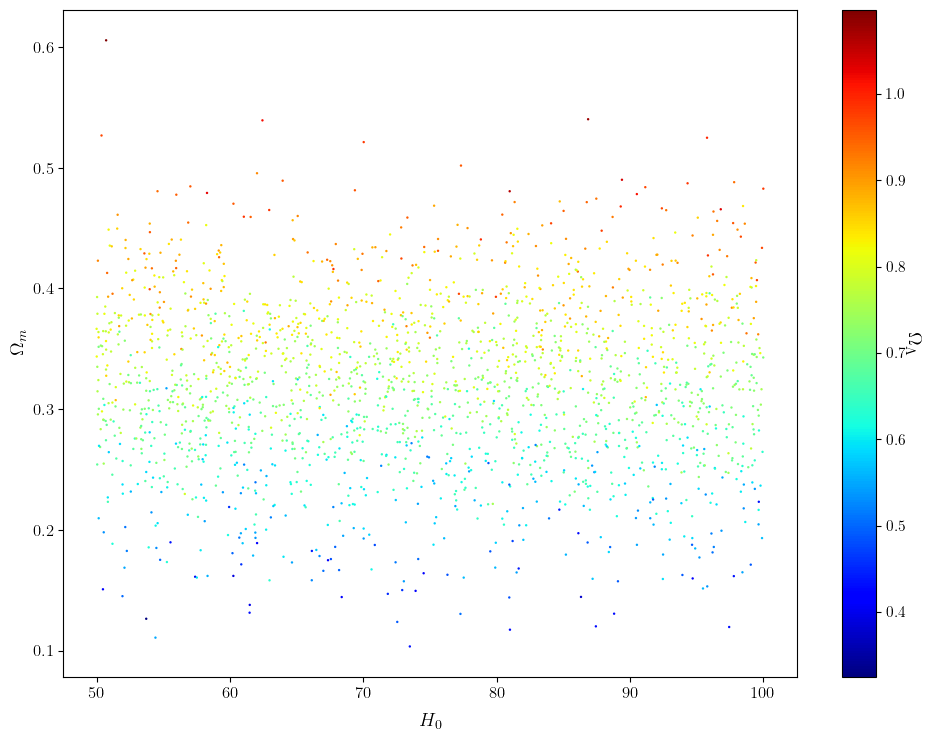

In [42]:
#2D scatter (3D) plot
g = plots.getSinglePlotter(width_inch=10)
g.settings.axes_fontsize = 12
g.plot_3d(gsamples, parnames)
pl.show()